In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import time

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

from pypf.tree import PfTree
from pypf._utils import print_tree

from pypf.sliding_distance import matches, min_distance
import matplotlib.pylab as plt

In [7]:
x = [
    [0, 0, 1, 10, 1],
    [0, 0, 1, 10, 1],
    [0, 1, 9, 1, 0],
    [1, 9, 1, 0, 0],
    [0, 1, 9, 1, 0],
    [0, 1, 2, 3, 4],
    [1, 2, 3, 0, 0],
    [0, 0, 0, 1, 2],
    [0, 0, -1, 0, 1],
    [1, 2, 3, 0, 1],
]
x = np.array(x, dtype=np.float64)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

random_state = np.random.RandomState(123)
order = np.arange(10)
random_state.shuffle(order)

x = x[order, :]
y = y[order]

tree = PfTree(random_state=10, scale=False)
tree.fit(x, y)
print_tree(tree.tree)

- branch:
-  shapelet:  [1. 9. 1.]
-  threshold:  3.582207001484488 ( ? )
-  left:
-- leaf: 
--  proba:  [1. 0.]
-  right:
-- leaf: 
--  proba:  [0. 1.]


In [8]:
print(min_distance(tree.tree.shapelet.array, x, 4, scale=False, return_index=True))

(9.219544457292887, 2)


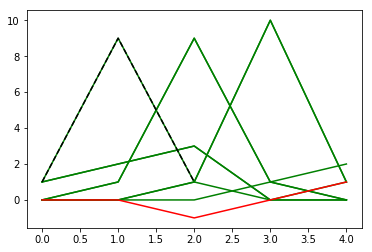

In [12]:
plt.plot(x[0:3, :].T, "g-")
plt.plot(x[5:, :].T, "g-")
plt.plot(x[4:5, :].T, "r-")
plt.plot(tree.tree.shapelet.array, "k--")

In [56]:
tree.predict(x[4:5, :])

array([1])

In [57]:
def move_to_threshold(s, t, theta):
    d, i = min_distance(s, t, return_index=True)
    t_match = t[i:(i + s.length)]
    s_arr = s.array
    v = t_match - s_arr
    p = s_arr - v / np.linalg.norm(v) * theta
    return p

dd = move_to_threshold(tree.tree.shapelet, x[4,:], tree.tree.threshold - 0.05)
x_trans = x.copy()
x_trans[4,0:3] = dd

(<pypf._sliding_distance.Shapelet object at 0x7f03dd650238>, True)


In [58]:
print(min_distance(tree.tree.shapelet.unscaled_array, x, sample=4, scale=False))

(array([1., 9., 1.]), False)
9.219544457292887


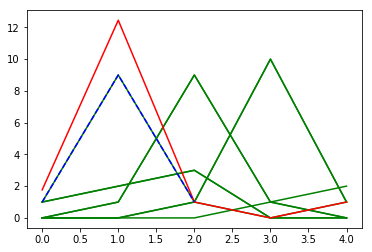

In [60]:
plt.plot(x_trans[0:3, :].T, "g-")
plt.plot(x_trans[5:, :].T, "g-")
plt.plot(x_trans[4:5, :].T, "r-")
plt.plot(tree.tree.shapelet.array, "b--")

In [63]:
tree.predict(x_trans[4:5,:])

array([0])